# <center>Apple stock price prediction</center>

Historical apple stock price data were obtained from Apple Inc. (AAPL), Currency in USD at finance.yahoo.com [1].

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tqdm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime, timezone, timedelta
import six
import sys
import pickle
sys.modules['sklearn.externals.six'] = six
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
mpl.rcParams['figure.dpi']=120
plt.rcParams["font.family"] = "arial"
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from yahoofinancials import YahooFinancials
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, roc_auc_score

/Users/yang/.pyenv/versions/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


We firstly downloaded the data, then we selected open price as dependent variable for prediction.

In [2]:
############################################
# Define a function to load data from yahoo
############################################
def get_finance(ticker, start_date='2007-12-31'):
    """Download finance data from finance.yahoo.com"""
    data0=pd.DataFrame(YahooFinancials(ticker).get_historical_price_data(start_date=start_date, 
        end_date=datetime.today().strftime('%Y-%m-%d'), 
        time_interval='daily')[ticker]['prices'])
    data0['Date']=pd.to_datetime(data0['formatted_date'])
    data1=data0.drop(columns=['date', 'formatted_date']).set_index('Date')
    return data1

In [3]:
apple0=get_finance('AAPL', start_date='2000-08-30')
##########################
# Delete Missing values
##########################
apple=apple0.dropna()
pd.DataFrame({' ' : ['Value'],
             'Original number of rows': [apple0.shape[0]],
             'Final number of rows': [apple.shape[0]],
             'Number of rows with NaN': [apple0.shape[0]-apple.shape[0]],
             'NaN rate': ['{:.2f}%'.format((apple0.shape[0]-apple.shape[0])/apple0.shape[0]*100)]}).set_index(' ').T

,Value
Original number of rows,5175
Final number of rows,5175
Number of rows with NaN,0
NaN rate,0.00%


In [4]:
# Describe of the data set.
apple.tail()

,high,low,open,close,volume,adjclose
Date,,,,,,
2021-03-22,123.870003,120.260002,120.330002,123.389999,111912300,123.389999
2021-03-23,124.239998,122.139999,123.330002,122.540001,95467100,122.540001
2021-03-24,122.900002,120.070000,122.820000,120.089996,88530500,120.089996
2021-03-25,121.660004,119.000000,119.540001,120.589996,98844700,120.589996
2021-03-26,121.480003,118.919998,120.349998,121.209999,93958900,121.209999


We focus on open prices as dependent variable, and subset the open column.

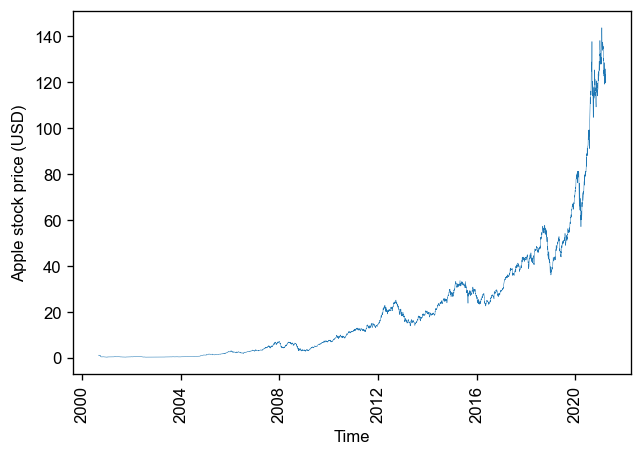

In [5]:
fig, ax=plt.subplots(1, 1)
ax.plot(apple[['open']], linewidth=0.3)
ax.set_xlabel('Time')
ax.set_ylabel('Apple stock price (USD)')
plt.xticks(rotation=90)
plt.show()

In [6]:
#####################################################
# Test whether apple stock price time series is random walk
#####################################################
adfuller_result=adfuller(apple['open'].diff().dropna())
pd.DataFrame({' ': ['Value'], 'ADF Statistic:': ['{:.3f}'.format(adfuller_result[0])],
             'p-value:': ['{:.9f}'.format(adfuller_result[1])],
              'Critical Values 1%:': ['{:.3f}'.format(list(adfuller_result[4].values())[0])],
              'Critical Values 5%:': ['{:.3f}'.format(list(adfuller_result[4].values())[1])],
              'Critical Values 10%:': ['{:.3f}'.format(list(adfuller_result[4].values())[2])]
             }).set_index(' ').T

,Value
ADF Statistic:,-11.517
p-value:,0.000000000
Critical Values 1%:,-3.432
Critical Values 5%:,-2.862
Critical Values 10%:,-2.567


With an extremely small p-value from an Augmented Dickey-Fuller test on the first order difference of the apple stock price time series, we can reject the null hypothesis of random walk, and conclude that the time series is not a random walk. It is possible to predict the apple stock price!

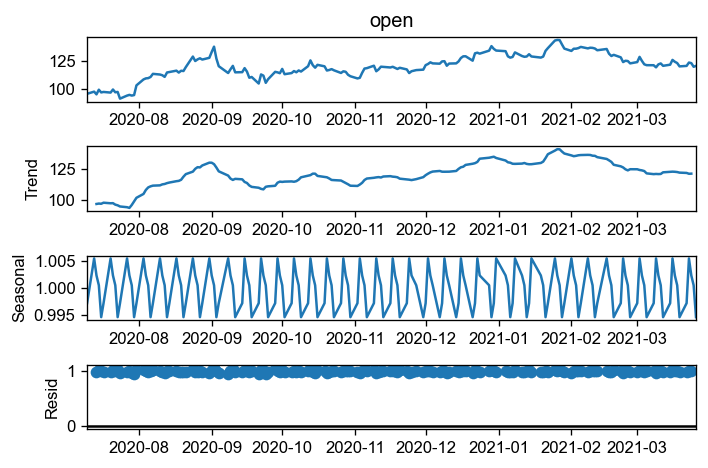

In [7]:
#####################################################################
# Decompose the apple stock price time series
#####################################################################
seasonal_decompose(apple['open'].iloc[-180:], model='multiplicative', period=5).plot()
plt.show()

It seems that the apple stock price has a seasonal component. It may due to a mean reversion: when the price gets higher, people want to sell, causing the price go lower, and then people want to buy, causing the price higher, again and again. One approach is using this mean reversion to make the model profitable (to make prediction by the behavior of apple stock price itself).

Next, we are going to find out if the apple stock price time series is stationary by autocorrelation function (ACF). 

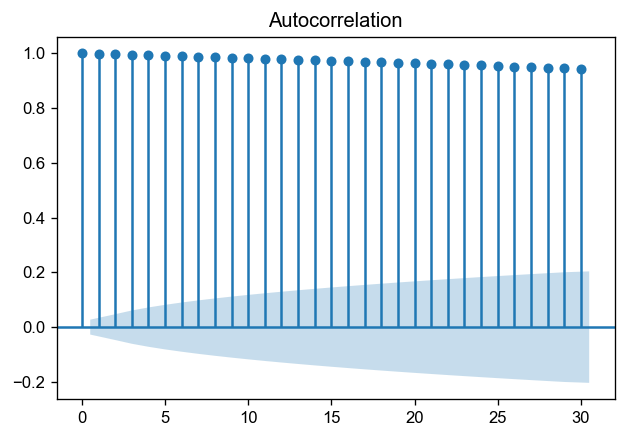

In [8]:
###################################################################################################################
# Autocorrelation investigation for apple stock price (95% confidence interval)
###################################################################################################################
_=plot_acf(apple['open'], lags=30, alpha=0.05)
plt.show()

The ACF plot of the original apple stock price time series is decreasing very slowly, and remains well above the significance range, indicating that the original airbnb stock price time series is non-stationary.

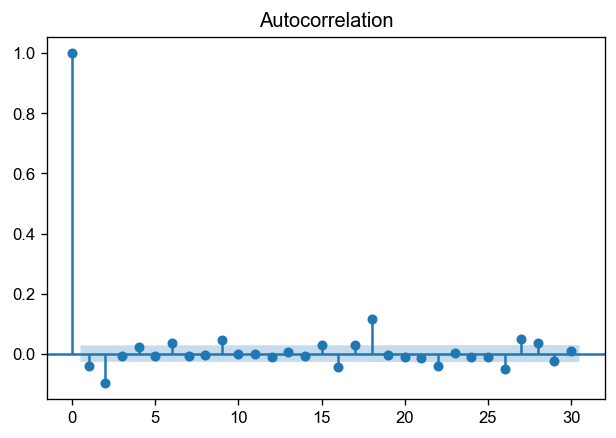

In [9]:
_=plot_acf(apple['open'].diff().dropna(), lags=30, alpha=0.05)
plt.show()

However, the first order difference makes the time series stationary. Actually, this plot has determined the order ($q$) of moving averages (M.A.) to be 1. Next we are going to find out the benefit of adding more $\phi$s by a partial autocorrelation function (PACF) to determine the order ($p$) of autogression (A.R.). From the below plot, we can see that $p$=2. Also, first order of difference can make the gold prices stationary, so the order of differencing $d$=1.

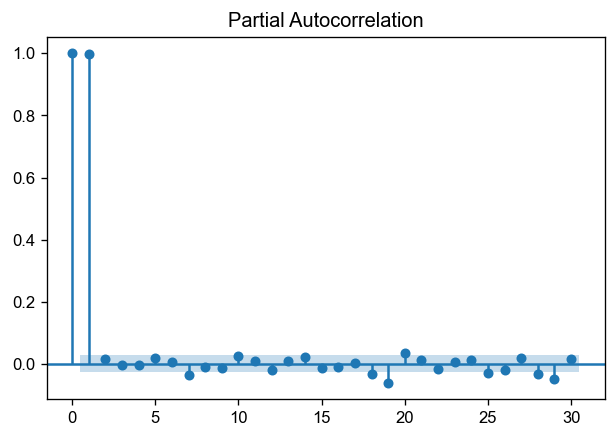

In [10]:
_=plot_pacf(apple['open'], lags=30, alpha=0.05)
plt.show()

Now we are going to use an Autoregressive Integrated Moving Averages (ARIMA) model to fit and predict the apple stock prices. ARIMA is well-known for forecasting stocks and financial market fluctuations, and data scientists and researchers have been utilizing ARIMA model to predict the price of gold [1,6]. Without helps of exogenous variables, we will see how good our prediction will be.

The goal of this project is to be profitable. We want this model be able to tell us in the morning, by the end of today or several days later, is the price going up or down. The model is going to be indicative for us whether we should bull the market or do short sale for the stock within several business days. Long-term prediction is not in the scope of this project.

In [11]:
##############################################
# Explore possible parameters with auto_arima
##############################################]
auto_arima_model=auto_arima(apple[['open']],
                      seasonal=True,
                      start_p=1,
                      start_q=1,
                      information_criterion='aic',
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True, m=5)
auto_arima_model.fit(apple[['open']])

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[5]             : AIC=inf, Time=1.04 sec
 ARIMA(0,2,0)(0,0,0)[5]             : AIC=15448.407, Time=0.05 sec
 ARIMA(1,2,0)(1,0,0)[5]             : AIC=14141.046, Time=0.16 sec
 ARIMA(0,2,1)(0,0,1)[5]             : AIC=inf, Time=0.61 sec
 ARIMA(1,2,0)(0,0,0)[5]             : AIC=14140.199, Time=0.09 sec
 ARIMA(1,2,0)(0,0,1)[5]             : AIC=14141.034, Time=0.16 sec
 ARIMA(1,2,0)(1,0,1)[5]             : AIC=14143.004, Time=0.38 sec
 ARIMA(2,2,0)(0,0,0)[5]             : AIC=13339.006, Time=0.11 sec
 ARIMA(2,2,0)(1,0,0)[5]             : AIC=13340.212, Time=0.26 sec
 ARIMA(2,2,0)(0,0,1)[5]             : AIC=13340.201, Time=0.22 sec
 ARIMA(2,2,0)(1,0,1)[5]             : AIC=13340.573, Time=0.72 sec
 ARIMA(3,2,0)(0,0,0)[5]             : AIC=12874.098, Time=0.14 sec
 ARIMA(3,2,0)(1,0,0)[5]             : AIC=12876.034, Time=0.32 sec
 ARIMA(3,2,0)(0,0,1)[5]             : AIC=12876.033, Time=0.27 sec
 ARIMA(3,2,0)(1,0,1)[5]        

ARIMA(order=(4, 2, 0), scoring_args={}, seasonal_order=(2, 0, 0, 5),
      suppress_warnings=True, with_intercept=False)

In [12]:
####################################################
# Fill missing dates
####################################################
Y=apple[['open']]
Y=Y.resample('D').ffill()
Y.tail()

,open
Date,
2021-03-22,120.330002
2021-03-23,123.330002
2021-03-24,122.820000
2021-03-25,119.540001
2021-03-26,120.349998


In [13]:
###############################################
# Train-validation-test split
###############################################
y_train=Y.loc[Y.index<pd.to_datetime("2016", format='%Y')]
y_validation=Y.loc[(Y.index>=pd.to_datetime("2016", format='%Y')) & (Y.index<pd.to_datetime("2019", format='%Y'))]
y_test=Y.loc[Y.index>=pd.to_datetime("2019", format='%Y')]

       True Positive  False Negative  False Positive  True Negative
Count             99               4               6             74
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        80
           1       0.94      0.96      0.95       103

    accuracy                           0.95       183
   macro avg       0.95      0.94      0.94       183
weighted avg       0.95      0.95      0.95       183



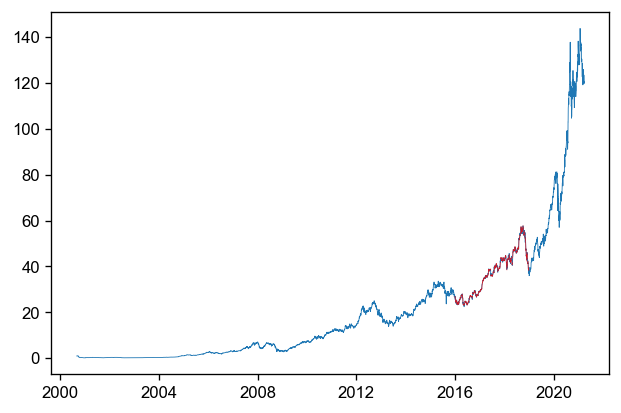

In [14]:
######################################################
# Train the model with train set and validation set
######################################################
day=6
####################################################
y_train_moving=y_train.copy()
prediction_results=pd.DataFrame(columns=['real', 'predict'])
##########################################
# Plot
##########################################
fig, ax=plt.subplots(1, 1)
ax.plot(Y.index, Y['open'], label='Open Price', linewidth=0.5)
##########################################
count=0
last_index=y_train_moving.index[-1]
real_value=y_train['open'].iloc[-1]
for index, row in y_validation.iterrows():
    if count%day==0:
        model_moving=sm.tsa.SARIMAX(y_train_moving, order=(2, 1, 1), seasonal_order=(2, 0, 0, 5)).fit()
        y_prediction=model_moving.predict(start=len(y_train_moving.index), end=len(y_train_moving.index)+day)
        prediction=pd.DataFrame({'Prediction': [real_value, y_prediction.values[-1]]}, 
                            index=[last_index, index])
        last_index=index
        real_value=row[0]
        ax.plot(prediction, alpha=0.7, linewidth=0.5, c='r')
    y_train_moving=y_train_moving.append(pd.DataFrame({'open': [row[0]]}, index=[index]))
    if count%day==0:
        prediction_results=prediction_results.append(pd.DataFrame(
            {'real': [y_train_moving['open'].iloc[-1]-y_train_moving['open'].iloc[-(day+1)]],
             'predict': [prediction['Prediction'].iloc[-1]-prediction['Prediction'].iloc[-2]]},
                                                index=[y_train_moving.index[-1]]))
    count+=1
###################################################
# Summary the prediction result
###################################################
prediction_results['bool_real']=prediction_results['real'].apply(lambda x: 1 if x>0 else 0)
prediction_results['bool_predict']=prediction_results['predict'].apply(lambda x: 1 if x>0 else 0)
cm=confusion_matrix(prediction_results['bool_real'], prediction_results['bool_predict'])
print(pd.DataFrame({' ': ['True Positive', 'False Negative', 'False Positive', 'True Negative'],
                       'Count': [cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]]}).set_index(' ').T)
print(classification_report(prediction_results['bool_real'], prediction_results['bool_predict']))
ax.set_xlabel('Time')
ax.set_ylabel('Apple stock price (USD)')
ax.legend(frameon=False)
plt.xticks(rotation=90)
plt.show()

       True Positive  False Negative  False Positive  True Negative
Count             78               9               7             42
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        49
           1       0.92      0.90      0.91        87

    accuracy                           0.88       136
   macro avg       0.87      0.88      0.87       136
weighted avg       0.88      0.88      0.88       136

Current apple stock open price is $120.35
Predicted apple stock open price after 6 days is $120.48
Price change is $0.13


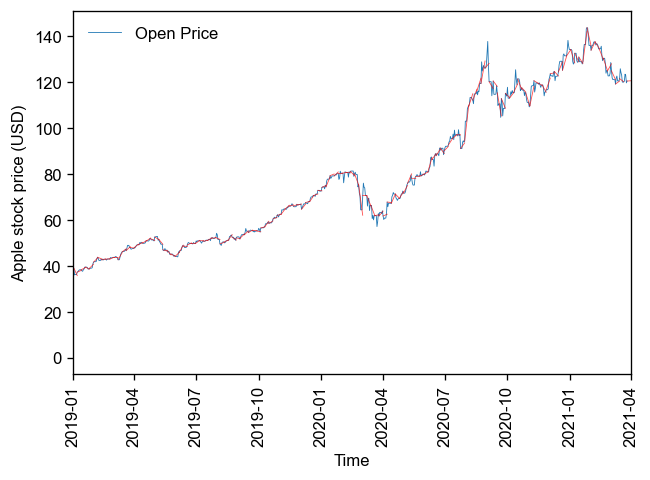

In [18]:
##########################################################
# Now use this model on test set to see how it gererates
##########################################################
day=6
y_train=Y.loc[Y.index<pd.to_datetime("2019", format='%Y')]
y_test=Y.loc[Y.index>=pd.to_datetime("2019", format='%Y')]
####################################################
y_train_moving=y_train.copy()
prediction_results=pd.DataFrame(columns=['real', 'predict'])
##########################################
# Plot
##########################################
fig, ax=plt.subplots(1, 1)
ax.plot(Y.index, Y['open'], label='Open Price', linewidth=0.5)
##########################################
count=0
last_index=y_train_moving.index[-1]
real_value=y_train['open'].iloc[-1]
for index, row in y_test.iterrows():
    if count%day==0:
        model_moving=sm.tsa.SARIMAX(y_train_moving, order=(2, 1, 1), seasonal_order=(2, 0, 0, 5)).fit()
        y_prediction=model_moving.predict(start=len(y_train_moving.index), end=len(y_train_moving.index)+day)
        prediction=pd.DataFrame({'Prediction': [real_value, y_prediction.values[-1]]}, 
                            index=[last_index, index])
        last_index=index
        real_value=row[0]
        ax.plot(prediction, alpha=0.7, linewidth=0.5, c='r')
    y_train_moving=y_train_moving.append(pd.DataFrame({'open': [row[0]]}, index=[index]))
    if count%day==0:
        prediction_results=prediction_results.append(pd.DataFrame(
            {'real': [y_train_moving['open'].iloc[-1]-y_train_moving['open'].iloc[-(day+1)]],
             'predict': [prediction['Prediction'].iloc[-1]-prediction['Prediction'].iloc[-2]]},
                                                index=[y_train_moving.index[-1]]))
    count+=1
###################################################
# Summary the prediction result
###################################################
prediction_results['bool_real']=prediction_results['real'].apply(lambda x: 1 if x>0 else 0)
prediction_results['bool_predict']=prediction_results['predict'].apply(lambda x: 1 if x>0 else 0)
cm=confusion_matrix(prediction_results['bool_real'], prediction_results['bool_predict'])
print(pd.DataFrame({' ': ['True Positive', 'False Negative', 'False Positive', 'True Negative'],
                       'Count': [cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]]}).set_index(' ').T)
print(classification_report(prediction_results['bool_real'], prediction_results['bool_predict']))
###################################################
# Predict the future
###################################################
model_moving=sm.tsa.SARIMAX(y_train_moving, order=(2, 1, 1), seasonal_order=(2, 0, 0, 5)).fit()
y_prediction=model_moving.predict(start=len(y_train_moving.index), end=len(y_train_moving.index)+day)
print('Current apple stock open price is ${:.2f}'.format(y_test['open'].iloc[-1]))
print('Predicted apple stock open price after {} days is ${:.2f}'.format(day, y_prediction.values[-1]))
print('Price change is ${:.2f}'.format(y_prediction.values[-1]-y_test['open'].iloc[-1]))
prediction=pd.DataFrame({'Prediction': [y_test['open'].iloc[-1], y_prediction.values[-1]]}, 
                            index=[y_test.index[-1], y_test.index[-1]+timedelta(day)])
ax.plot(prediction, alpha=0.7, linewidth=0.5, c='r')
ax.set_xlabel('Time')
ax.set_ylabel('Apple stock price (USD)')
ax.legend(frameon=False)
plt.xticks(rotation=90)
ax.set_xlim([pd.to_datetime("2019-01-01", format='%Y-%m-%d'), y_test.index[-1]+timedelta(day)])
plt.show()

Now we have a good model, and the next question is: how to make this model most profitable. In other words, what is our strategy to trade Apple stocks according to the information provided by this model?

In [19]:
###################################
# define stock class
###################################
class Stock(object):
    def __init__(self, time):
        self.time=time
        self.open=np.nan
        self.predict=np.nan        

In [20]:
###############################
# Make a list of apple stocks
###############################
applelist=list()
for index, row in Y.iterrows():
    applelist.append(Stock(index))
    applelist[-1].open=row[0]

In [21]:
##################################################################################################
# First attempt: follow the six day cycle since the six day prediction is accurate
# Assume we start to make money from September 2020 by this model: we want to avoid the huge rise
##################################################################################################
day=6
####################################################################################
y_train=Y.loc[Y.index<pd.to_datetime("2016", format='%Y')]
y_test=Y.loc[Y.index>=pd.to_datetime("2016", format='%Y')]
y_train_moving=y_train.copy()
count=0
last_index=y_train_moving.index[-1]
real_value=y_train['open'].iloc[-1]
for index, row in y_test.iterrows():
    if count%day==0:
        model_moving=sm.tsa.SARIMAX(y_train_moving, order=(2, 1, 1), seasonal_order=(2, 0, 0, 5)).fit()
        y_prediction=model_moving.predict(start=len(y_train_moving.index), end=len(y_train_moving.index)+day)
        for stock in applelist:
            if stock.time==index+timedelta(day):
                stock.predict=y_prediction.values[-1]
                break
        last_index=index
        real_value=row[0]
    y_train_moving=y_train_moving.append(pd.DataFrame({'open': [row[0]]}, index=[index]))
    count+=1

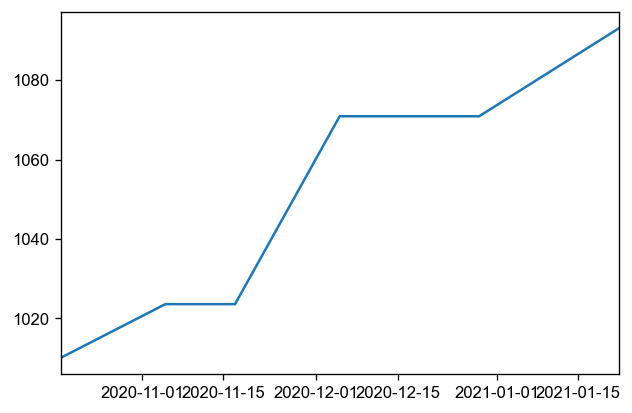

From september 2020 to today, we can earn $93.10


In [22]:
#################################################################################################
# Try different strategy to trade apple stock: simply buy and sell when seeing the predict value
#################################################################################################
applelist2020=[stock for stock in applelist if stock.time>=pd.to_datetime('2020-09', format='%Y-%m')]
money=1000.0
money_trace=[]
time_trace=[]
share=0.0
today_real=0.0
today_predict=0.0
next_predict=0.0
next_real=0.0
last_buy_price=0.0
for index, stock in enumerate(applelist2020):
    if not np.isnan(stock.predict):
        today_real=stock.open
        today_predict=stock.predict
        step=0
        while (index+step)<len(applelist2020)-1:
            step+=1
            if not np.isnan(applelist2020[index+step].predict):
                next_predict=applelist2020[index+step].predict
                next_real=applelist2020[index+step].open
                middle_prices=[]
                for i in range(1, step):
                    middle_prices.append(applelist2020[index+i].open)
                break
        if share<0.1 and today_real<next_predict: #buy
            share=money/today_real
            money=0.0
            last_buy_price=today_real
        if money<0.1 and today_real>next_predict and today_real>last_buy_price: #sell
            money=share*today_real
            share=0.0
        if not money<0.1:
            money_trace.append(money)
            time_trace.append(stock.time)
            
_=plt.plot(time_trace, money_trace)
_=plt.xlim([min(time_trace), max(time_trace)])
plt.show()
print('From september 2020 to today, we can earn ${:.2f}'.format(money_trace[-1]-1000))

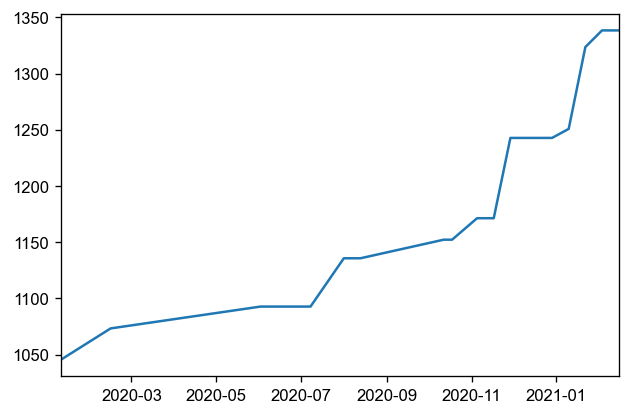

From September 2020 to today, we can earn $338.50


In [23]:
#################################################################################################
# Try different strategy to trade apple stock: find an optimited value to buy and sell
#################################################################################################
applelist2020=[stock for stock in applelist if stock.time>=pd.to_datetime('2020', format='%Y')]
money=1000.0
money_trace=[]
time_trace=[]
share=0.0
today_real=0.0
today_predict=0.0
next_predict=0.0
next_real=0.0
last_buy_price=0.0
for index, stock in enumerate(applelist2020):
    if not np.isnan(stock.predict):
        today_real=stock.open
        today_predict=stock.predict
        step=0
        while (index+step)<len(applelist2020)-1:
            step+=1
            if not np.isnan(applelist2020[index+step].predict):
                next_predict=applelist2020[index+step].predict
                next_real=applelist2020[index+step].open
                middle_prices=[]
                for i in range(1, step):
                    middle_prices.append(applelist2020[index+i].open)
                break
        if share<0.1 and today_real<next_predict: #buy
            if middle_prices[0]>=today_real:
                buy_price=middle_prices[0]
            elif middle_prices[1]>=middle_prices[0]:
                buy_price=middle_prices[1]
            elif middle_prices[2]>=middle_prices[1]:
                buy_price=middle_prices[2]
            elif middle_prices[3]>=middle_prices[2]:
                buy_price=middle_prices[3]
            elif middle_prices[4]>=middle_prices[3]:
                buy_price=middle_prices[4]
            else:
                buy_price=middle_prices[5]
            share=money/buy_price
            money=0.0
            last_buy_price=buy_price
        if money<0.1 and today_real>next_predict: #sell
            if middle_prices[0]<=today_real:
                sell_price=middle_prices[0]
            elif middle_prices[1]<=middle_prices[0]:
                sell_price=middle_prices[1]
            elif middle_prices[2]<=middle_prices[1]:
                sell_price=middle_prices[2]
            elif middle_prices[3]<=middle_prices[2]:
                sell_price=middle_prices[3]
            elif middle_prices[4]<=middle_prices[3]:
                sell_price=middle_prices[4]
            else:
                sell_price=middle_prices[5]
            if sell_price>last_buy_price:
                money=share*sell_price
                share=0.0
        if not money<0.1:
            money_trace.append(money)
            time_trace.append(stock.time)
            
_=plt.plot(time_trace, money_trace)
_=plt.xlim([min(time_trace), max(time_trace)])
plt.show()
print('From September 2020 to today, we can earn ${:.2f}'.format(money_trace[-1]-1000))

### References

[1] https://finance.yahoo.com

